<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics, pt. 2</h2>

# Table of Contents

* [Part 3](#part3): Preprocessing
    * [3.1](#3_1): Missing values
    * [3.2](#3_2): Conversion
    * [3.3](#3_3): Scaling
    * [3.4](#3_4): Feature engineering
    * [3.5](#3_5): Encoding
<br />
<br />
* [Part 4](#part4): Exploratory data analysis

## Notebook Setup

In [280]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [281]:
df = pd.read_csv('csv-files/project_lvl.csv')

## Part 3: <a class="anchor" id="part3"></a> Preprocessing

### 3.1 <a class="anchor" id="3_1"></a> Missing values

In [282]:
# Number of columns having null values in the dataset
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 115
Project_Size_Sort_Order 1
Project_Duration_Weeks 456
Total_Num_Stages 3
Is_Multi_Discipline_Project 1
Is_First_Client_Project 1
Perc_of_Stages_with_Fixed_Fee 3
Manager_Is_Recent 455
Director_ID 1
Director_Team 1
Director_Is_Recent 456
Director_Empl_Months 1
Perc_of_Subcontractors 595
Is_Front_Loaded 275
Delivered_on_Time 531
Total_Data_Issues 3
Avg_Rec 627
Avg_Profit 627


In [283]:
len(df.columns)

25

In [284]:
# URL: https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
df['non_missing_count'] = df.apply(lambda x: x.count(), axis=1)
df['non_missing_count'].value_counts()

25    9017
18     311
17     122
24     110
21      82
20      68
19      24
22      18
14       1
23       1
15       1
Name: non_missing_count, dtype: int64

Rows with more than 5 empty columns will be dropped, so the minimum number of non-missing columns per row should be 17.

In [285]:
print('Minimum values each column should have is set to be at least half of the dataset, i.e. '+ str(round(0.70 * len(df.columns)))+' rows.')

Minimum values each column should have is set to be at least half of the dataset, i.e. 18 rows.


In [286]:
df1 = df[(df['non_missing_count']) >= 18]
len(df1)

9631

In [287]:
len(df) - len(df1)

124

In [288]:
# Number of columns having null values in the dataset
df = df1
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 115
Project_Duration_Weeks 334
Manager_Is_Recent 333
Director_ID 1
Director_Team 1
Director_Is_Recent 334
Director_Empl_Months 1
Perc_of_Subcontractors 471
Is_Front_Loaded 151
Delivered_on_Time 408
Avg_Rec 503
Avg_Profit 503


First, let's deal with small amount of nulls.

In [289]:
# Drop ID columns and those with too many missing values
df = df1

# Replacing null values with the most frequent strings and booleans - look up how to distribute them randomly, instead of most popular!
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Director_ID'].fillna(df['Director_ID'].value_counts().idxmax(), inplace = True)
df['Director_Team'].fillna(df['Director_Team'].value_counts().idxmax(), inplace = True)
df['Director_Is_Recent'].fillna(df['Director_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Manager_Is_Recent'].fillna(df['Manager_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Director_Empl_Months'].fillna(df['Director_Empl_Months'].value_counts().idxmax(), inplace = True)
df['Is_Front_Loaded'].fillna(df['Is_Front_Loaded'].value_counts().idxmax(), inplace = True)
df['Delivered_on_Time'].fillna(df['Delivered_on_Time'].value_counts().idxmax(), inplace = True)

Whether to perform imputatipon of missed values with median or mean, always depends on data and task.If there is a dataset that have great outliers, or the distribution oof values does not follow the normal distribution, medians are preferred.

In [290]:
# Using median to impute the missing float values

missing_weeks = ['Project_Duration_Weeks']
for s in missing_weeks:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_subcontractors = ['Perc_of_Subcontractors']
for s in missing_subcontractors:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_rec = ['Avg_Rec']
for r in missing_rec:
    df.loc[df.loc[:,r].isnull(),r]=df.loc[:,r].median()
    
missing_profit = ['Avg_Profit']
for p in missing_profit:
    df.loc[df.loc[:,p].isnull(),p]=int(df.loc[:,p].median())

In [291]:
# Verify the changes
df.isnull().sum()

Project_ID                       0
Country                          0
Office                           0
Sector                           0
Project_Size_Sort_Order          0
Project_Duration_Weeks           0
Total_Num_Stages                 0
Is_Multi_Discipline_Project      0
Is_First_Client_Project          0
Default_Rate_Group               0
Perc_of_Stages_with_Fixed_Fee    0
Manager_ID                       0
Manager_Team                     0
Manager_Is_Recent                0
Manager_Empl_Months              0
Director_ID                      0
Director_Team                    0
Director_Is_Recent               0
Director_Empl_Months             0
Perc_of_Subcontractors           0
Is_Front_Loaded                  0
Delivered_on_Time                0
Total_Data_Issues                0
Avg_Rec                          0
Avg_Profit                       0
non_missing_count                0
dtype: int64

In [292]:
df.drop(columns = ['non_missing_count', 'Project_ID'], inplace = True)

### 3.2 <a class="anchor" id="3_2"></a> Conversion

In [293]:
# Convert the object column to boolean
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(bool)
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(int)
df['Is_First_Client_Project'] = df['Is_First_Client_Project'].astype(int)
df['Manager_Is_Recent'] = df['Manager_Is_Recent'].astype(int)
df['Is_Front_Loaded'] = df['Is_Front_Loaded'].astype(int)

### 3.3 <a class="anchor" id="3_3"></a> Scaling

<AxesSubplot:title={'center':'Relationship between profit and recoverability'}, xlabel='Avg_Rec', ylabel='Avg_Profit'>

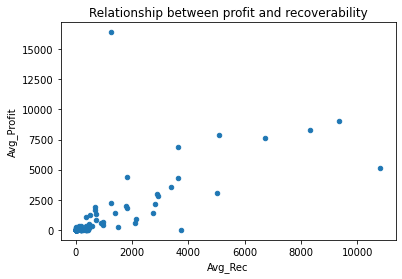

In [294]:
# No scaling
df.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')

<AxesSubplot:title={'center':'Relationship between profit and recoverability'}, xlabel='Avg_Rec', ylabel='Avg_Profit'>

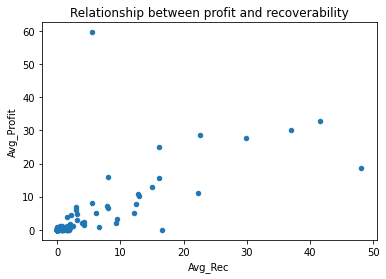

In [295]:
# Standardisation
df_std = df.copy()
df_std[['Avg_Rec', 'Avg_Profit']] = StandardScaler().fit_transform(df_std[['Avg_Rec', 'Avg_Profit']])
df_std.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')

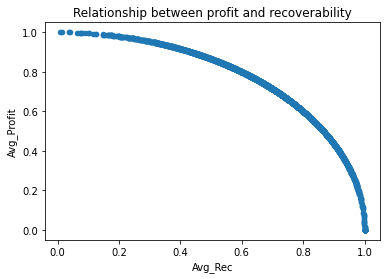

In [296]:
# Normalization
df_norm = df.copy()
df_norm[['Avg_Rec', 'Avg_Profit']] = preprocessing.normalize(df_norm[['Avg_Rec', 'Avg_Profit']])
df_norm.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')
df = df_norm

### 3.4 <a class="anchor" id="3_4"></a> Feature engineering

#### 3.4.1 <a class="anchor" id="3_4_1"></a> Recoverability

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


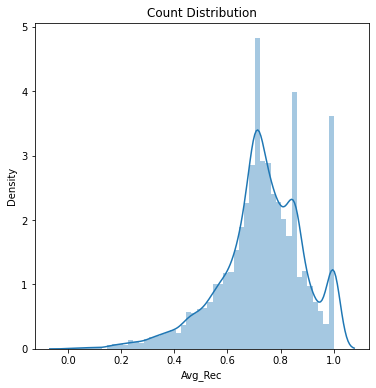

In [297]:
#Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.distplot(df['Avg_Rec'])
plt.title('Count Distribution')
plt.show()

<AxesSubplot:>

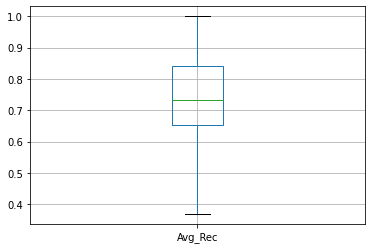

In [298]:
df.boxplot('Avg_Rec', showfliers=False) # boxplot without outliers, the green line corresponds to the median

Interpretation: https://www.mathbootcamps.com/how-to-read-a-boxplot/

<AxesSubplot:>

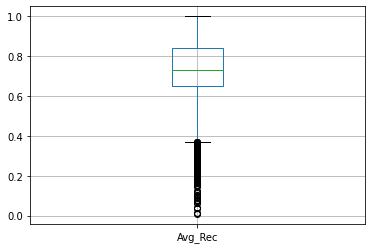

In [299]:
df.boxplot('Avg_Rec')

In [300]:
# Calculate the minimum and maximum bounds aside outliers
q25, q75 = percentile(df['Avg_Rec'], 25), percentile(df['Avg_Rec'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper, df['Avg_Rec'].median())

0.36815858766524 1.1257672886546348 0.7327905817411604


Now we can create 3 recoverability classes based on the median recoverability as our threshold.

In [301]:
rec_class = {}
for rec in df['Avg_Rec']:
  if rec < 0.36815858766524:
    rec_class[rec] = 0  # nearly unrecoverable projects are all outliers below the lower bound
  elif rec > 0.7327905817411604:
    rec_class[rec] = 2 # very recoverable projects are higher than median
  else:
    rec_class[rec] = 1 # average recoverable projects are those between the median and lower bound

In [302]:
rec_class_df = pd.DataFrame([{'Avg_Rec': rec, 'Rec_Class': rec_class} for (rec, rec_class) in rec_class.items()])
rec_class_df

,Avg_Rec,Rec_Class
0,0.901941,2
1,1.000000,2
2,0.832050,2
3,0.782964,2
4,0.750596,2
...,...,...
7913,0.955782,2
7914,0.755472,2
7915,0.642735,1
7916,0.716994,1


#### 3.4.2 <a class="anchor" id="3_4_2"></a> Profit

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


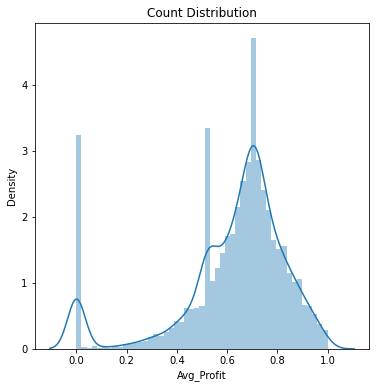

In [303]:
#Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.distplot(df['Avg_Profit'])
plt.title('Count Distribution')
plt.show()

<AxesSubplot:>

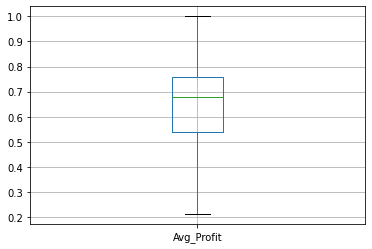

In [304]:
df.boxplot('Avg_Profit', showfliers=False) # boxplot without outliers, the green line corresponds to the median

<AxesSubplot:>

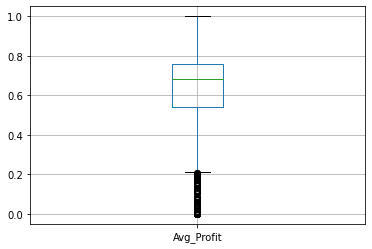

In [305]:
df.boxplot('Avg_Profit')

In [306]:
# Calculate the minimum and maximum bounds aside outliers
q25, q75 = percentile(df['Avg_Profit'], 25), percentile(df['Avg_Profit'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper, df['Avg_Profit'].median())

0.21301326350608785 1.0849819904763902 0.6804542330762973


Now we can create 3 profit measure classes based on the median profit measurement as our threshold.

In [307]:
profit_class = {}
for pr in df['Avg_Profit']:
  if pr < 0.21301326350608785:
    profit_class[pr] = 0  # nearly unprofitable projects are all outliers below the lower bound
  elif pr > 0.6804542330762973:
    profit_class[pr] = 2 # very profitable projects are higher than median
  else:
    profit_class[pr] = 1 # average profitable projects are those between the median and lower bound

In [308]:
pr_class_df = pd.DataFrame([{'Avg_Profit': pr, 'Profit_Class': profit_class} for (pr, profit_class) in profit_class.items()])
pr_class_df

,Avg_Profit,Profit_Class
0,0.431859,1
1,0.000000,0
2,0.554700,1
3,0.622067,1
4,0.660761,1
...,...,...
7911,0.294077,1
7912,0.655181,1
7913,0.766088,2
7914,0.697079,2


#### 3.4.3 <a class="anchor" id="3_4_3"></a> Incorporation of new classes

In [309]:
df = pd.merge(df, rec_class_df,  how='left', on='Avg_Rec')
df = pd.merge(df, pr_class_df,  how='left', on='Avg_Profit')

### 3.5 <a class="anchor" id="3_3"></a> Encoding

#### 3.5.1 <a class="anchor" id="3_5_1"></a> One hot encoding

In [310]:
cat_vars = (df.select_dtypes(include=object))
cat_vars.columns

Index(['Country', 'Office', 'Sector', 'Default_Rate_Group', 'Manager_Team',
       'Director_Team'],
      dtype='object')

In [311]:
df['Country'].nunique()

12

In [312]:
df['Office'].nunique()

8

In [313]:
df['Sector'].nunique()

12

In [314]:
df['Default_Rate_Group'].nunique()

2

In [315]:
df['Manager_Team'].nunique()

22

In [316]:
df['Manager_Team'].value_counts()

SA - Civil                         2153
SA - Industrial                    1757
SA - Buildings                     1725
VIC - Buildings                    1207
VIC - Support Services              455
All Staff                           428
Group - Support Services            300
WA - Structural                     240
WA - Industrial                     200
WA - Maritime                       191
NZ - Water                          141
QLD - QLD                           126
WA - Civil                          124
VIC - Traffic                       123
WA - Project Delivery Services      108
SA - Project Delivery Services       88
VIC - Infrastructure                 83
VIC - Industrial                     81
VIC - Project Delivery Services      59
WA - Support Services                21
VIC - Geotechnical                   20
SA - Finance                          1
Name: Manager_Team, dtype: int64

In [317]:
for x in df['Manager_Team']:
    if x.startswith('SA') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'SA', inplace=True)
    elif x.startswith('VIC') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'VIC', inplace=True)
    elif x.startswith('WA') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'WA', inplace=True)
    elif x.startswith('NZ') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'NZ', inplace=True)
    elif x.startswith('QLD') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'QLD', inplace=True)

In [318]:
df['Manager_Team'].value_counts()

SA                          5724
VIC                         2028
WA                           884
All Staff                    428
Group - Support Services     300
NZ                           141
QLD                          126
Name: Manager_Team, dtype: int64

In [319]:
df['Manager_Team'].nunique()

7

In [320]:
df['Director_Team'].nunique()

16

In [321]:
df['Director_Team'].value_counts()

SA - Buildings                    2391
SA - Industrial                   1926
VIC - Support Services            1752
SA - Civil                        1668
WA - Maritime                      668
Group - Support Services           608
VIC - Buildings                    184
WA - Structural                    136
SA - Project Delivery Services      88
WA - Civil                          73
VIC - Traffic                       61
VIC - Infrastructure                47
VIC - Geotechnical                  10
All Staff                            8
QLD - QLD                            6
NZ - Water                           5
Name: Director_Team, dtype: int64

In [322]:
for x in df['Director_Team']:
    if x.startswith('SA') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'SA', inplace=True)
    elif x.startswith('VIC') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'VIC', inplace=True)
    elif x.startswith('WA') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'WA', inplace=True)
    elif x.startswith('NZ') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'NZ', inplace=True)
    elif x.startswith('QLD') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'QLD', inplace=True)

In [323]:
df['Director_Team'].value_counts()

SA                          6073
VIC                         2054
WA                           877
Group - Support Services     608
All Staff                      8
QLD                            6
NZ                             5
Name: Director_Team, dtype: int64

In [324]:
df['Director_Team'].nunique()

7

In [327]:
df_extended = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True, dtype=None)
df_extended

,Project_Size_Sort_Order,Project_Duration_Weeks,Total_Num_Stages,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Stages_with_Fixed_Fee,Manager_ID,Manager_Is_Recent,Manager_Empl_Months,Director_ID,Director_Is_Recent,Director_Empl_Months,Perc_of_Subcontractors,Is_Front_Loaded,Delivered_on_Time,Total_Data_Issues,Avg_Rec,Avg_Profit,Rec_Class,Profit_Class,Country_Botswana,Country_China,Country_Malaysia,Country_New Zealand,Country_Papua New Guinea,Country_Peru,Country_Samoa,Country_Saudi Arabia,Country_Tonga,Country_United Arab Emirates,Country_Zambia,Office_Inception Consulting Engineers Pty Ltd,Office_WGANZ Pty Ltd,Office_WGAQLD Pty Ltd,Office_WGASA Pty Ltd,Office_WGAVIC Pty Ltd,Office_WGAWA Pty Ltd,Office_Whyalla,Sector_Commercial & Retail Buildings,Sector_Defence & Space,Sector_Energy,Sector_Health & Aged Care,"Sector_Justice, Corrections & Emergency Services",Sector_Ports & Marine,Sector_Resources,Sector_Sport & Recreation Facilities,Sector_Traffic Transport (Bridges),Sector_Urban development,Sector_Water/Waste,Default_Rate_Group_Standard,Manager_Team_Group - Support Services,Manager_Team_NZ,Manager_Team_QLD,Manager_Team_SA,Manager_Team_VIC,Manager_Team_WA,Director_Team_Group - Support Services,Director_Team_NZ,Director_Team_QLD,Director_Team_SA,Director_Team_VIC,Director_Team_WA
0,4.0,4.0,5.0,0,1,0.80,7612852,0,125.0,7612709.0,False,431.0,0.0,1,True,2.0,0.901941,0.431859,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
1,1.0,238.0,4.0,0,1,0.00,7612773,0,317.0,7612747.0,False,431.0,0.0,0,True,2.0,1.000000,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,1.0,0.0,2.0,0,1,0.00,7612773,0,317.0,7612768.0,False,337.0,0.0,0,True,0.0,0.832050,0.554700,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
3,3.0,121.0,4.0,0,1,0.25,7612773,0,317.0,7612709.0,False,431.0,0.0,0,True,1.0,0.782964,0.622067,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,7.0,2.0,6.0,0,1,0.00,7612695,0,419.0,7612695.0,False,419.0,0.0,0,True,3.0,1.000000,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9626,3.0,18.0,2.0,0,0,1.00,7612752,0,176.0,7612691.0,False,175.0,0.0,0,True,1.0,0.853686,0.520788,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
9627,1.0,1.0,3.0,0,0,0.67,9501752,0,11.0,7859152.0,False,28.0,0.0,0,True,1.0,0.853686,0.520788,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9628,1.0,1.0,2.0,0,0,0.50,7809410,0,28.0,10018105.0,True,4.0,0.0,0,True,1.0,0.853686,0.520788,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9629,1.0,3.0,1.0,0,0,1.00,7612860,0,168.0,7612841.0,False,286.0,0.0,0,True,0.0,0.853686,0.520788,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### 3.5.2 <a class="anchor" id="3_5_2"></a> Label encoding

In [265]:
#le = LabelEncoder()
#df['Country'] = le.fit_transform(df['Country'])
#df['Office'] = le.fit_transform(df['Office'])
#df['Sector'] = le.fit_transform(df['Sector'])
#df['Default_Rate_Group'] = le.fit_transform(df['Default_Rate_Group'])
#df['Manager_Team'] = le.fit_transform(df['Manager_Team'])
#df['Director_Team'] = le.fit_transform(df['Director_Team'])
#df['Director_Is_Recent'] = df['Director_Is_Recent']*1
#df['Delivered_on_Time'] = df['Delivered_on_Time']*1

## Part 4: <a class="anchor" id="part4"></a> Exploratory data analysis

### 4.1 <a class="anchor" id="4_1"></a> Target variables

In [93]:
all_bins = pd.DataFrame(df, columns = ['Avg_Rec', 'Avg_Profit'])
bins_prep = pd.merge(all_bins, rec_class_df,  how='left', on='Avg_Rec')
bins_prep = pd.merge(bins_prep, pr_class_df,  how='left', on='Avg_Profit')
bins_prep

,Avg_Rec,Avg_Profit,Rec_Class,Profit_Class
0,0.901941,0.431859,2,1
1,1.000000,0.000000,2,0
2,0.832050,0.554700,2,1
3,0.782964,0.622067,2,1
4,1.000000,0.000000,2,0
...,...,...,...,...
9626,0.853686,0.520788,2,1
9627,0.853686,0.520788,2,1
9628,0.853686,0.520788,2,1
9629,0.853686,0.520788,2,1


In [94]:
bins_prep['Rec_Class'].value_counts()

2    4815
1    4529
0     287
Name: Rec_Class, dtype: int64

In [95]:
rec_classes = pd.DataFrame({'categories': ['unrecoverable', 'average', 'highly recoverable'],
                              'project_count': [287, 4529, 4815]})
rec_classes

,categories,project_count
0,unrecoverable,287
1,average,4529
2,highly recoverable,4815


Text(0.5, 0, 'Recoverability category')

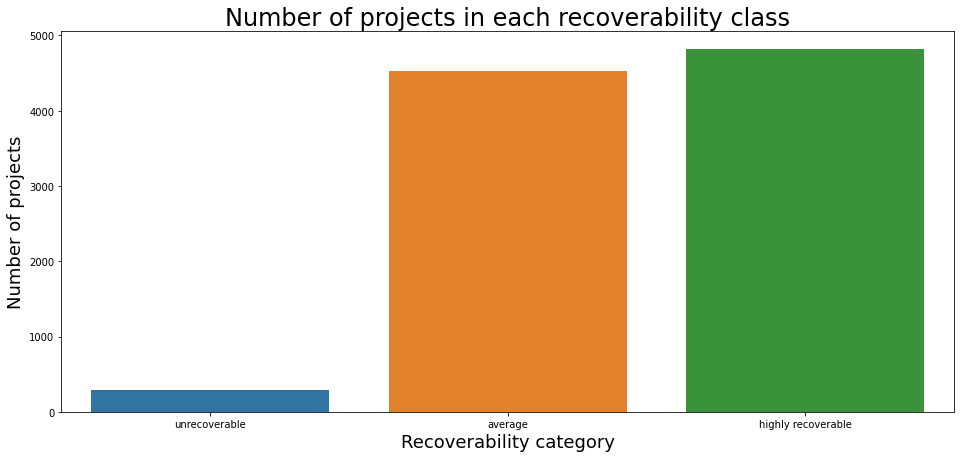

In [96]:
# Seaborn Visualisation
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'categories', y = 'project_count', data = rec_classes)
plt.title('Number of projects in each recoverability class', fontsize=24)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Recoverability category', fontsize=18)

In [97]:
bins_prep['Profit_Class'].value_counts()

2    4815
1    4115
0     701
Name: Profit_Class, dtype: int64

In [98]:
pr_classes = pd.DataFrame({'categories': ['unprofitable', 'average', 'highly profitable'],
                              'project_count': [701, 4115, 4815]})
pr_classes

,categories,project_count
0,unprofitable,701
1,average,4115
2,highly profitable,4815


Text(0.5, 0, 'Profitability category')

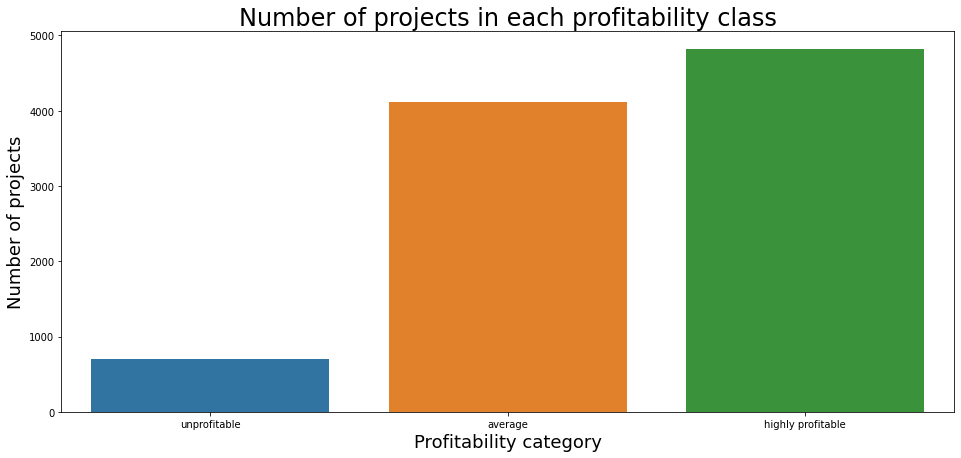

In [99]:
# Seaborn Visualisation
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'categories', y = 'project_count', data = pr_classes)
plt.title('Number of projects in each profitability class', fontsize=24)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Profitability category', fontsize=18)

### 4.2 <a class="anchor" id="4_2"></a> Extended dataframe

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_7620\1645786289.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, color='#f68c1f', alpha=0.1)


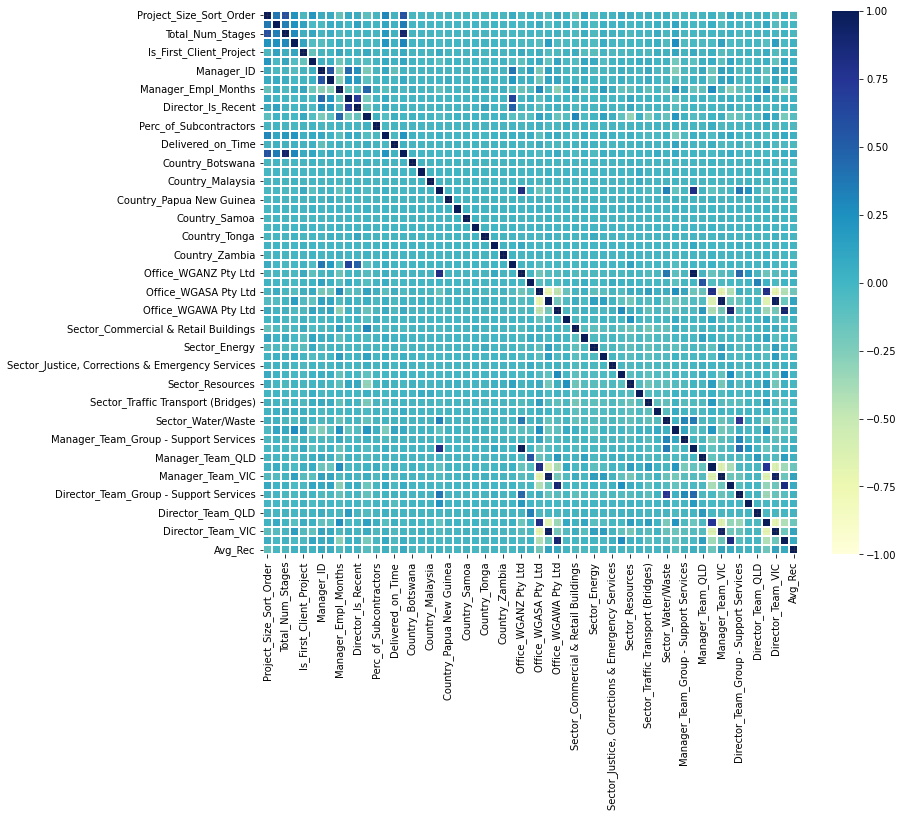

In [345]:
X = df_extended.drop(['Avg_Rec', 'Avg_Profit', 'Rec_Class', 'Profit_Class'], axis = 1).copy()
X['Avg_Rec'] = df['Avg_Rec']

corr = X.corr()
plt.figure(figsize = (12,10))

sns.heatmap(round(corr, 3), vmin=-1, vmax=1, cmap='YlGnBu', linewidths=.2)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()

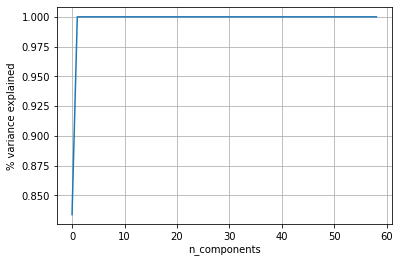

In [347]:
# URL: https://colab.research.google.com/drive/1_QnP8Xu-HukCjB3q5UyxPpXRkjmfzNYf?usp=sharing#scrollTo=_ewOfno1v0U6

pca = PCA(n_components = X.shape[1])
pca_data = pca.fit_transform(X)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('% variance explained')
plt.show()

In [348]:
cumm_var_explained

array([0.83397416, 0.99999975, 0.99999989, 0.99999995, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_7620\224021286.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, color='#f68c1f', alpha=0.1)


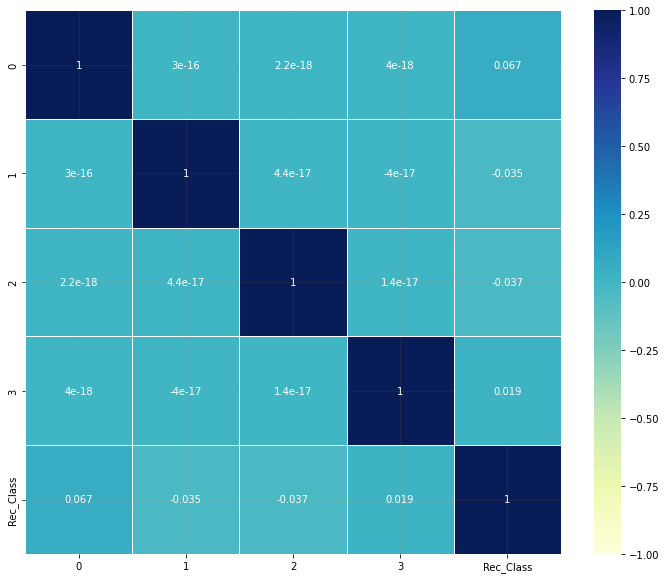

In [349]:
pca = PCA(n_components=4)
pca_X = pca.fit_transform(X)

df_pca_X = pd.DataFrame(pca_X)
df_pca_X['Rec_Class'] = df['Rec_Class']

corr = df_pca_X.corr()
plt.figure(figsize = (12,10))

sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap='YlGnBu', linewidths=.5)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()

### 4.3 <a class="anchor" id="4_3"></a> Extended dataframe

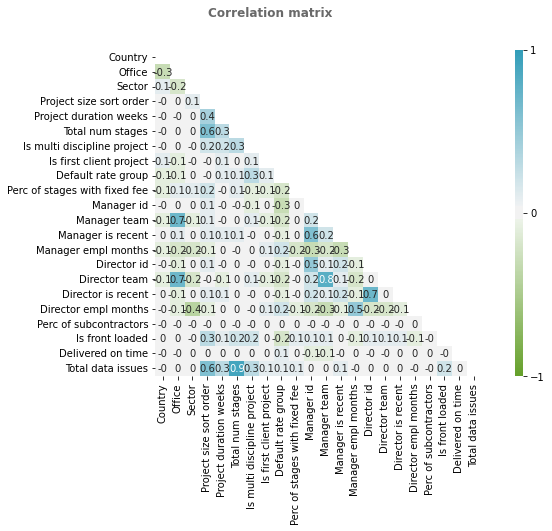

In [267]:
# Corelation matrix

corr_matrix = X.corr().round(1)
fig, ax = plt.subplots(figsize = (12, 6), ncols = 1, nrows = 1)
fig.suptitle('Correlation matrix',
             color = '#696969',
             weight = 'bold',
             size = 12)
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
labels = [name.capitalize().replace("_", " ") for name in corr_matrix.columns]

ax = sns.heatmap(data = corr_matrix, 
                 mask = mask,
                 vmin = -1,
                 vmax = 1,
                 square = True, 
                 annot = True,
                 xticklabels = labels,
                 yticklabels = labels,
                 cmap = sns.diverging_palette(115, 220, l = 60, s = 90, sep = 10, as_cmap = True),
                 cbar_kws = {
                     'orientation' : 'vertical', 
                     'shrink' : 1,
                     'aspect' : 40})

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-1.0, 0, 1.0])

In [270]:
# URL: https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/

# Create correlation matrix
corr_mat = X.corr(method='pearson')
  
# Retain upper triangular values of correlation matrix and make Lower triangular values Null
upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()
print(sorted_mat)

Director_Empl_Months  Sector               -0.440368
Manager_Empl_Months   Manager_Is_Recent    -0.280665
Director_Empl_Months  Manager_Team         -0.267269
Manager_Empl_Months   Manager_ID           -0.267161
Manager_ID            Default_Rate_Group   -0.256191
                                              ...   
Manager_Team          Office                0.677170
Director_Is_Recent    Director_ID           0.713496
Director_Team         Office                0.740897
                      Manager_Team          0.752020
Total_Data_Issues     Total_Num_Stages      0.910751
Length: 231, dtype: float64


C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_7620\3050897398.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))


### 4.3 <a class="anchor" id="4_3"></a> Outliers

In [102]:
# URL: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Rec'], 25), percentile(df['Avg_Rec'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Rec'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Rec'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.652, 75th=0.842, IQR=0.189
Identified outliers: 287
Non-outlier observations: 9344


In [103]:
# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Profit'], 25), percentile(df['Avg_Profit'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Profit'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Profit'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.540, 75th=0.758, IQR=0.218
Identified outliers: 701
Non-outlier observations: 8930


In [223]:
#URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [104]:
df.drop(columns = ['Project_ID'], inplace = True)
df.to_csv('csv-files/preprocessed_data.csv', index=False)